In [1]:
%cd ../

/home/hoanghu/projects/Food-Waste-Optimization/experiments_hoangle


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import pipeline
from sklearn.decomposition import PCA

from utils import Paths

In [3]:
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})

# Load data

In [4]:
dim_lunches = pd.read_excel(Paths.dim_lucnhes(), index_col=None, parse_dates=['date'])
dim_lunches.head()

,date,restaurant,category,meal,pcs
0,2023-01-02,Chemicum,fish,Kalapuikot tillikermaviilikast,78
1,2023-01-02,Chemicum,meat,Uunimakkaraa,165
2,2023-01-02,Chemicum,vegan,Marokkolainen linssipata,84
3,2023-01-03,Chemicum,fish,Herkkulohipihvit,105
4,2023-01-03,Chemicum,fish,Kalapuikot tillikermaviilikast,52


# Use language model to extract dish name embedding

## Load BERT and Finnish-GPT2

In [5]:
pipeline_dishname = pipeline('feature-extraction', model='Finnish-NLP/gpt2-medium-finnish')
pipeline_category = pipeline('feature-extraction', model='google-bert/bert-base-uncased')

/home/hoanghu/miniforge3/envs/fw/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Encode dish names and categories

In [6]:
dishes = dim_lunches['meal'].unique()
list_embds = pipeline_dishname(dishes.tolist())

embds_dish = np.float32([np.squeeze(embd).mean(axis=0) for embd in list_embds])

In [7]:
categories = dim_lunches['category'].unique()
list_embds = pipeline_category(categories.tolist())

embds_cat = np.float32([np.squeeze(embd).mean(axis=0) for embd in list_embds])

## Use PCA to reduce dim

### With embeddings of dish names

In [8]:
pca_dish = PCA().fit(embds_dish)
pca_cat = PCA().fit(embds_cat)

Text(0, 0.5, 'Cumulative explained variance')

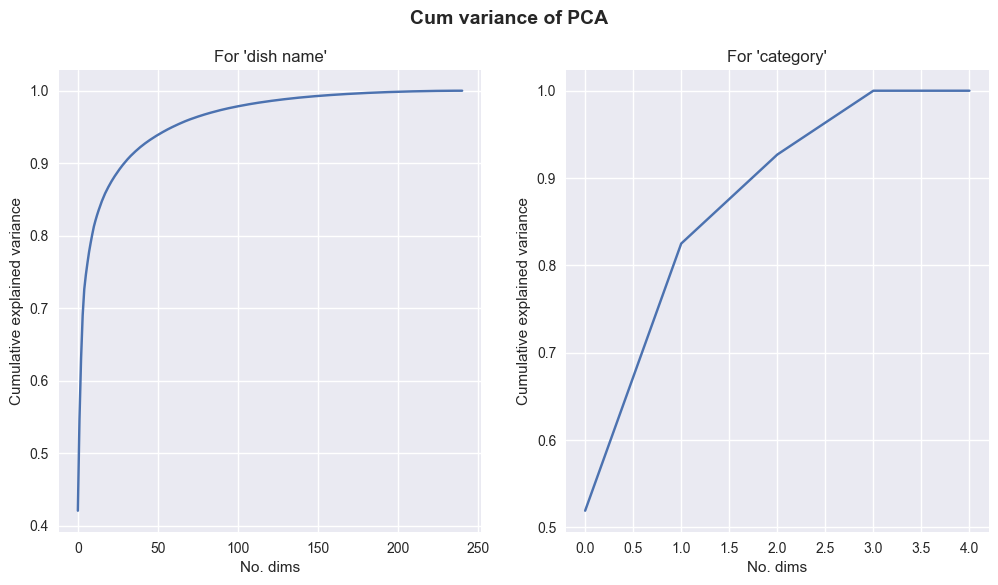

In [9]:
fig = plt.figure(figsize=(12, 6))
fig.suptitle("Cum variance of PCA", fontsize=14, fontweight='bold')

# Plot for 'dish'
xs = np.arange(embds_dish.shape[0])
ys = np.cumsum(pca_dish.explained_variance_ratio_)

ax = fig.add_subplot(121)
ax.set_title("For 'dish name'")

sns.lineplot(x=xs, y=ys, ax=ax)
ax.set_xlabel('No. dims')
ax.set_ylabel('Cumulative explained variance')

# Plot for 'category'
xs = np.arange(embds_cat.shape[0])
ys = np.cumsum(pca_cat.explained_variance_ratio_)

ax = fig.add_subplot(122)
ax.set_title("For 'category'")

sns.lineplot(x=xs, y=ys, ax=ax)
ax.set_xlabel('No. dims')
ax.set_ylabel('Cumulative explained variance')

=> From above figures, optimal `n_components` for PCA of dish name and category are `100` and `3`

In [10]:
embds_dish_reduced = PCA(100).fit_transform(embds_dish)
embds_cat_reduced = PCA(3).fit_transform(embds_cat)

# Save embeddings

In [18]:
map_dish2embd = {
    dish: embd
    for dish, embd in zip(dishes, embds_dish_reduced)
}

np.save(Paths.res_dish2embd(), map_dish2embd)

In [19]:
map_cat2embd = {
    cat: embd
    for cat, embd in zip(dishes, embds_cat_reduced)
}

np.save(Paths.res_cat2embd(), map_cat2embd)

# Load embeddings from saved file
# a = np.load(path_res_dish2embd, allow_pickle=True).item()